## Meteorological computations

In this notebook you will see:
- how to compute the potential temperature from GRIB data
- how to compute the wind speed from GRIB data

### Components of earthkit

This tutorial uses the following earthkit components - click any logo to open the package documentation:

<div align="center">
  <br>
  <a href="https://earthkit-data.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-data-light.svg" alt="earthkit-data" width="200">
  </a>
  <a href="https://earthkit-meteo.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-meteo-light.svg" alt="earthkit-meteo" width="200">
  </a>
  <a href="https://earthkit-plots.readthedocs.io/en/latest/" target="_blank" style="display:inline-block; margin: 0 15px;">
    <img src="https://raw.githubusercontent.com/ecmwf/logos/refs/heads/main/logos/earthkit/earthkit-plots-light.svg" alt="earthkit-plots" width="200">
  </a>
</div>

### 1. Getting the data

Get the input data containing temperature, specific humidity and wind analysis on pressure levels.

In [1]:
import earthkit as ek

ds = ek.data.from_source("sample", "tquv_pl_2x2.grib")
ds.head(6)

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,t,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,q,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
2,ecmf,u,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
3,ecmf,v,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
4,ecmf,t,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll
5,ecmf,q,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll


### 2. About earthkit-meteo

[earthkit-meteo](https://earthkit-meteo.readthedocs.io/en/latest/) is a collection of various meteorological and statistical computations. It is still work in progress and at the moment both the input and output have to be arrays (numpy, torch or CuPy). In the examples below you will see how to use earthkit-meteo computations with GRIB input and how to write the results into GRIB output. This requires writing a loop and performing the computations and GRIB encodings field by field.

### 3. Computing potential temperature

This example shows how to compute the potential temperature with [earthkit.meteo.thermo.potential_temperature](https://earthkit-meteo.readthedocs.io/en/latest/autoapi/earthkit/meteo/thermo/array/potential_temperature.html#earthkit.meteo.thermo.array.potential_temperature).

In [2]:
from earthkit.meteo import thermo

# select temperature fields
t = ds.sel(param="t")

res = []

# loop and perform the computation per field, i.e per level
for f in t:
    pres_pa = f.metadata("level") * 100 # Pa
    t_vals = f.values
    
    # do the computation
    pt_vals = thermo.potential_temperature(t_vals, pres_pa)
    print(f"t_mean={t_vals.mean():.2f} p={pres_pa} pt_mean={pt_vals.mean():.2f}")

    # encode a new GRIB field with the right shortName (in memory)
    md = f.metadata().override(shortName="pt")
    f_new = f.copy(values=pt_vals, metadata=md)
    
    res.append(f_new)

# create the resulting fieldlist    
ds_pt = ek.data.FieldList.from_fields(res)

t_mean=283.60 p=100000 pt_mean=283.60
t_mean=277.18 p=85000 pt_mean=290.35
t_mean=269.78 p=70000 pt_mean=298.72
t_mean=255.20 p=50000 pt_mean=311.09
t_mean=244.23 p=40000 pt_mean=317.31
t_mean=230.08 p=30000 pt_mean=324.54


Check the results.

In [3]:
ds_pt.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,pt,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,pt,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll
2,ecmf,pt,isobaricInhPa,700,20180801,1200,0,an,0,regular_ll
3,ecmf,pt,isobaricInhPa,500,20180801,1200,0,an,0,regular_ll
4,ecmf,pt,isobaricInhPa,400,20180801,1200,0,an,0,regular_ll
5,ecmf,pt,isobaricInhPa,300,20180801,1200,0,an,0,regular_ll


The resulting fieldlist was created in memory. You can save it into a file with `to_target()`.

In [4]:
ds_pt.to_target("file", "_pt_res.grib")

# read back saved data and check first 2 fields
ek.data.from_source("file", "_pt_res.grib").head(2)

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,pt,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,pt,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll


The next cell plots the input temperature and the computed potential temperature fields on the same level.

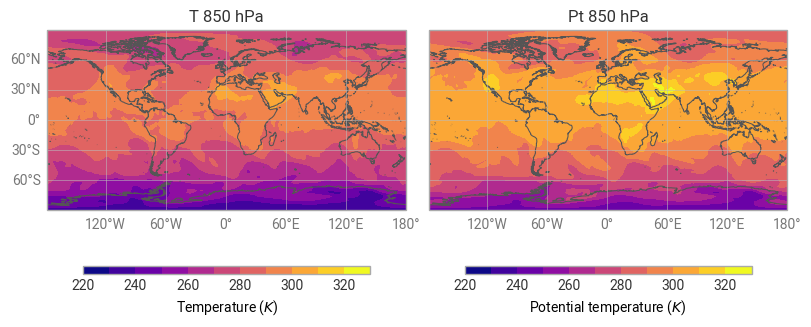

In [5]:
figure = ek.plots.Figure(rows=1, columns=2)

level = 850
t_style = ek.plots.styles.Style(
    units="K", levels=list(range(220,340,10))
)

subplot = figure.add_map(0, 0)
subplot.contourf(t.sel(level=level), style=t_style)
subplot.title("{shortName} {level} hPa")
subplot.legend()

subplot = figure.add_map(0, 1)
subplot.contourf(ds_pt.sel(level=level), style=t_style)
subplot.title("{shortName} {level} hPa")
subplot.legend()

figure.coastlines()
figure.gridlines()

figure.show()

### 4. Computing the wind speed

This example computes the wind speed with  [earthkit.meteo.wind.speed](https://earthkit-meteo.readthedocs.io/en/latest/autoapi/earthkit/meteo/wind/array/speed.html#earthkit.meteo.wind.array.speed).

In [6]:
from earthkit.meteo import wind

# select the u and v fields. We assume here they
# are valid for the same set of levels
u = ds.sel(param="u")
v = ds.sel(param="v")

res = []

# loop and perform the computation per field, i.e per level
for f_u, f_v in zip(u, v):
    u_vals = f_u.values
    v_vals = f_v.values
    
    # do the computation
    ws_vals = wind.speed(u_vals, v_vals)
   
    # encode a new GRIB field with the right shortName (in memory)
    md = f_u.metadata().override(shortName="ws")
    f_new = f.copy(values=ws_vals, metadata=md)
    
    res.append(f_new)

# create the resulting fieldlist    
ds_ws = ek.data.FieldList.from_fields(res)

Check the results.

In [7]:
ds_ws.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,ws,isobaricInhPa,1000,20180801,1200,0,an,0,regular_ll
1,ecmf,ws,isobaricInhPa,850,20180801,1200,0,an,0,regular_ll
2,ecmf,ws,isobaricInhPa,700,20180801,1200,0,an,0,regular_ll
3,ecmf,ws,isobaricInhPa,500,20180801,1200,0,an,0,regular_ll
4,ecmf,ws,isobaricInhPa,400,20180801,1200,0,an,0,regular_ll
5,ecmf,ws,isobaricInhPa,300,20180801,1200,0,an,0,regular_ll


The next cell plots the wind arrows and the computed speed over a subarea for a given level.

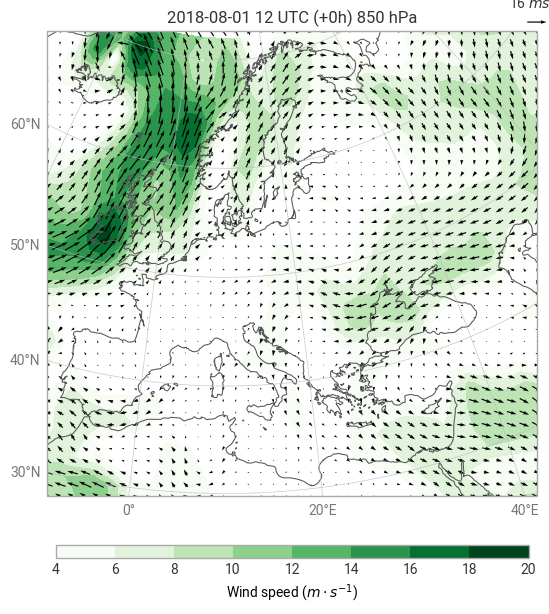

In [8]:
import cartopy.crs as ccrs

level = 850

chart = ek.plots.Map(domain="Europe", size=(6,6))
chart.contourf(ds_ws.sel(level=level), units="m s-1", colors="Greens", 
               levels=list(range(4,22,2)), alpha=1)
chart.quiver(u=u.sel(level=level), v=v.sel(level=level))
chart.coastlines()
chart.gridlines()
chart.legend()
chart.title(("{time:%Y-%m-%d %H} UTC (+{lead_time}h) {level} hPa"))

chart.show()

### Exercises

1. Write code to compute the **relative humidity** from temperature (t) and specific humidity (q) with [meteo.thermo.relative_humidity_from_specific_humidity](https://earthkit-meteo.readthedocs.io/en/latest/autoapi/earthkit/meteo/thermo/array/relative_humidity_from_specific_humidity.html#earthkit.meteo.thermo.array.relative_humidity_from_specific_humidity)
1. Plot the computed relative humidity fields

Hints:
- Use Chapter 3 as a template. You need to loop through the t and q fields together (use zip for it just like in Chapter 4)
- The ecCodes GRIB shortName to set for relative humidity is "r"
- You can quickly plot a given level from the results e.g. with `ek.plots.quickplot(ds_r.sel(level=700)).show()` (assuming the result is called "ds_r").

Solutions:
- see solutions/compute_rel_hum.ipynb